In [37]:
import random
# Install required libraries
# Import required libraries
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

print(device)
CUDA_LAUNCH_BLOCKING=1

cuda


In [2]:
# Definition of the Grid Environment class.

class GridEnvironment(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = { 'render.modes': [] }

    # Initialization function
    def __init__(self):

      self.observation_space = spaces.Discrete(36)
      self.action_space = spaces.Discrete(6)
      self.max_timesteps = 150

      self.timestep = 0
      self.agent_pos = [0, 0]
      self.goal_pos = [5, 5]
      self.package_pos = [3, 1]
      self.state = np.zeros((6,6))
      #Shelves
      self.wall_1 = [3,2]
      self.wall_2 = [4,2]
      self.wall_3 = [5,2]
      self.wall_4 = [1,4]
      self.wall_5 = [1,5]
      self.state[tuple(self.agent_pos)] = 50
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12

      self.package = 0
      self.pickup = 0

    # Reset function
    def reset(self, **kwargs):

      self.state = np.zeros((6,6))
      self.agent_pos = [0, 0]
      self.state[tuple(self.agent_pos)] = 50
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12
      self.timestep = 0
      observation = self.state.flatten()
      self.package =0
      info = {}

      return observation, info

    # Step function: Contains the implementation for what happens when an
    # agent takes a step in the environment.
    def step(self, action):
      prev = self.agent_pos.copy()
      if action == 0: #down
        self.agent_pos[0] += 1
      if action == 1: #up
        self.agent_pos[0] -= 1
      if action == 2: #right
        self.agent_pos[1] += 1
      if action == 3: #left
        self.agent_pos[1] -= 1

      reward = -1
      if action == 4: # Pick up
        if np.array_equal(self.agent_pos, self.package_pos) and self.package == 0: #Picked up, in right location
          self.package = 1
          reward = 40
          #print("picked up", self.timestep)
          #self.pickup += 1
        elif self.package: #Picked up while holding a package
          reward = -100
        else: # Picked up in wrong location
          reward = -10

      if action == 5:
        #Drop off
        if np.array_equal(self.agent_pos, self.goal_pos) and self.package == 1: #Dropped off in right location
          reward = 100
          #print("dropped off", self.timestep)
          self.package = 0
          self.timestep = self.max_timesteps
        elif self.package == 0: #Dropped off without holding a package
          reward = -100
        else: #dropped off in wrong location
          reward -10

      if np.array_equal(self.agent_pos, self.wall_1) or np.array_equal(self.agent_pos, self.wall_2) or np.array_equal(self.agent_pos, self.wall_3) or np.array_equal(self.agent_pos, self.wall_4) or np.array_equal(self.agent_pos, self.wall_5):
        reward = -20
        self.agent_pos = prev
        #print("wall")

      # Comment this to demonstrate the truncation condition.
      if self.agent_pos[0] > 5 or self.agent_pos[0] < 0 or self.agent_pos[1] > 5 or self.agent_pos[1] < 0:
        reward = -25
        #print("bounding: ", self.agent_pos)
      self.agent_pos = np.clip(self.agent_pos, 0, 5)

      self.state = np.zeros((6,6))
      self.state[tuple(self.goal_pos)] = 23
      self.state[tuple(self.package_pos)] = 5
      self.state[tuple(self.wall_1)] = 12
      self.state[tuple(self.wall_2)] = 12
      self.state[tuple(self.wall_3)] = 12
      self.state[tuple(self.wall_4)] = 12
      self.state[tuple(self.wall_5)] = 12
      self.state[tuple(self.agent_pos)] = 50
      observation = self.state.flatten()


      self.timestep += 1

      # Condition to check for termination (episode is over)
      terminated = True if self.timestep >= self.max_timesteps else False

      # Condition to check if agent is traversing to a cell beyond the permitted cells
      # This helps the agent to learn how to behave in a safe and predictable manner
      truncated = True if np.all((np.asarray(self.agent_pos) >=0 ) & (np.asarray(self.agent_pos) <= 6)) else False
      #print(self.agent_pos)

      return observation, reward, terminated, self.package

    # Render function: Visualizes the environment
    def render(self):
      plt.title('Grid Environment')
      plt.imshow(self.state)

In [7]:
class Net(nn.Module):

    def __init__(self, obs, action):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(obs, 144)
        self.layer2 = nn.Linear(144, 144)
        self.layer3 = nn.Linear(144, action)

    def forward(self, x):
        #print(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [8]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        self.capacity = capacity

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [49]:


class DQN:
  # initialize values
  def __init__(self, N, C):
    # initialize environment
    self.env = GridEnvironment()
    # initialize replay memory to capacity N
    self.replay = ReplayMemory(N)
    self.pointer = 0
    self.policy_net = Net(2, 6).to(device)
    self.target_net = Net(2, 6).to(device)

    self.optimizer = optim.SGD(self.policy_net.parameters(), lr=0.01)

    self.C = C
    pass

  
  # Main training function
  def train(self, episodes, epsilon, discount, action_function):
    total_reward = [0] * episodes  
    TAU = .0004
    for i in range(episodes):
      # initialize sequence S and preprocessed sequence o
      seq  = [None , None]
      seq[0] = torch.tensor([0, 0],device=device, dtype=torch.float32).unsqueeze(0)
      terminated = False
      pos = package = rewards = t = 0
      self.env.reset()
      while not terminated:
        # Select action
        action_type = action_function(epsilon ** i, pos, package)
        state = torch.tensor([pos, package], device=device, dtype=torch.float32).unsqueeze(0)
        # Set sequence
        seq[1] = state
        # Execute action and observe reward
        position, reward, terminated, package = self.env.step(action_type.item())
        pos = np.where(position == 50)[0][0]
        rewards += reward
        reward = torch.tensor([reward], device=device)
        # store transition in replay buffer
        self.replay.push(seq[0], action_type,  seq[1], reward)
        seq[0] = state
        
        self.optimize_function(discount)

        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]* TAU + target_net_state_dict[key]*(1- TAU)
        
        if t % self.C == 0:    
            self.target_net.load_state_dict(target_net_state_dict)
        

      # Decay epsilon after every episode
      total_reward[i] = rewards  
    return total_reward
  # Determine the action for the warehouse environment
  def warehouse_action(self, epsilon, pos, package):
      if np.random.rand() < epsilon:
        action_type = np.random.randint(6)
      else:
        with torch.no_grad():
            state = torch.tensor([pos, package], device=device, dtype=torch.float32).unsqueeze(0)
            return self.policy_net(state).max(1).indices.view(1, 1) 
      return torch.tensor([[action_type]], device=device, dtype=torch.long)
      
  def optimize_function(self, discount):
    BATCH_SIZE = 128
    if len(self.replay) < BATCH_SIZE:
        return
    else:
        transitions = self.replay.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        expected_state_action_values = (next_state_values * discount) + reward_batch
             
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
              

  # Save the current weights
  def save(self, filename):
    with open("pickles/" + filename, 'wb') as file:
      pickle.dump(self.policy_net, file)


In [9]:
#Prints the reward per episode graph
def reward_print(reward_per_episode, episodes, info): 
    mins = int(min(reward_per_episode)) + int(min(reward_per_episode)) * (.2)
    maxs = int(max(reward_per_episode)) - int(max(reward_per_episode)) * (.2) 
    plt.figure()
    plt.plot(reward_per_episode)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Cumulative Reward', fontsize=20)
    plt.title(f'Cumulative Reward Per Episode ({info})', fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin= mins, ymax=maxs)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()

#prints the epsilon decay graph
def ep_decay(eps, episodes):
    epsilon_values = [(eps ** i) * 1 for i in range(episodes)]
    plt.figure()
    plt.plot(epsilon_values, linewidth=4)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Epsilon Value', fontsize=20)
    plt.title(f"Epsilon Decay for {eps}", fontsize=24)
    plt.xticks([0, episodes * .2, episodes * .4, episodes * .6, episodes * .8, episodes], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=episodes)
    plt.grid()
    plt.show()


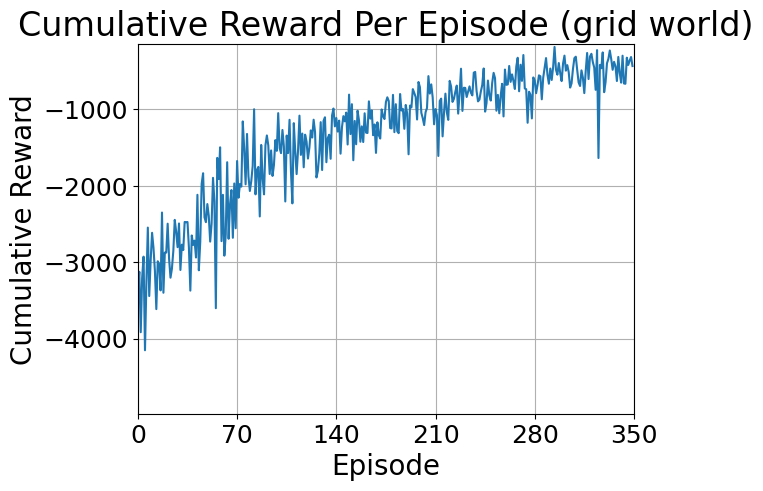

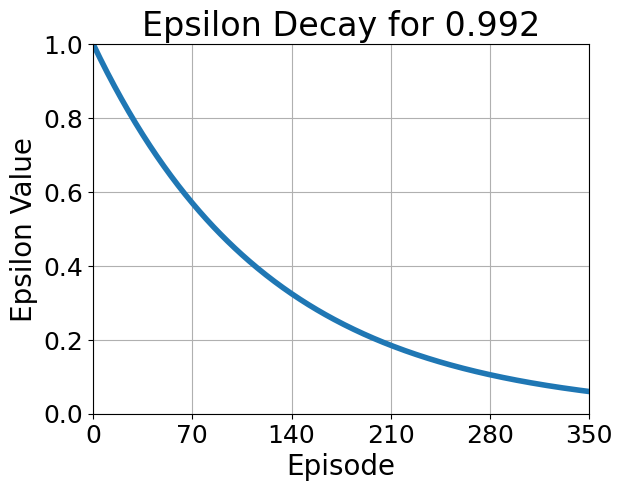

In [50]:
N = 5000
C = 10
env = GridEnvironment()
agent = DQN(N, C)

episodes = 350
epsilon = .992
discount = .4
action = agent.warehouse_action
total_rewards = agent.train(episodes, epsilon, discount, action)
agent.save("grid_world")
reward_print(total_rewards, episodes, "grid world")
ep_decay(epsilon, episodes)

In [22]:
envc = gym.make("CartPole-v1")

envc.reset()

obs, reward, term, trunc, _ = envc.step(0)

print(len(obs))

4
